# Chapter 15 IDIOSYNCRATIC VOLATILITY

According to many asset pricing models, including the Capital Asset Pricing Model (CAPM, Sharpe (1964), Lintner (1965), Mossin (1966)) and arbitrage pricing theory (APT, Ross (1976)),firm-specific risk does not command a risk premium.
The empirical implication of this is that measures of firm-specific risk, or risk that is not related to a systematic factor, should exhibit no relation with future stock returns.


Merton’s model implicates that, in equilibrium, firm-specific risk is priced. Specifically, there is a positive risk premium associated with firm-specific risk.


The most widely cited study of the cross-sectional relation between firm-specific risk and expected stock returns is Ang, Hodrick, Xing, and Zhang(2006),which finds a strong negative cross-sectional relation between idiosyncratic volatility and future stock returns. This result is highly inconsistent with the predictions of all theoretical models.

There are two frequently used approaches to calculating the total volatility of a stock’s returns. 

# 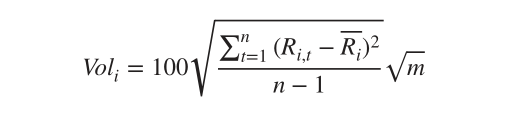

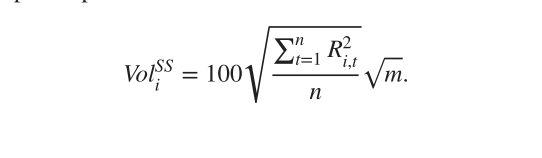

Idiosyncratic volatility is measured as the residual standard error from a time-series regression of periodic excess stock returns on the returns of factor-mimicking port-folios. The model used most frequently to calculate idiosyncratic volatility is the Fama and French (1993) three-factor (FF) model.

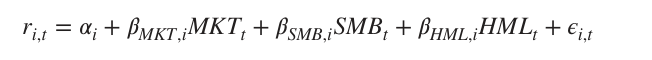

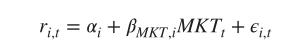

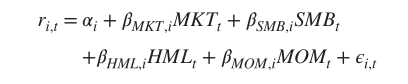

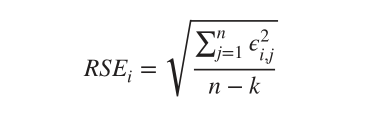

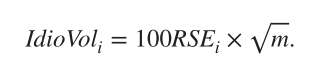

In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import glob
import statsmodels.formula.api as smf
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
pd.set_option('display.width', 5000)
import math
from sklearn.linear_model import LinearRegression
import os 
os.chdir(r'F:\第15章')

In [ ]:
ff=pd.read_csv('fivefactor_daily.csv') 

stock = pd.read_csv('公司文件.csv') 
stock1=stock.drop(index=3275)
stock1=stock1[(stock1['Markettype']=="1")|(stock1['Markettype']=="4")|(stock1['Markettype']=="16")|(stock1['Markettype']=="32")]  #保留所有A股
stock1=stock1[stock1['Indnme']!="金融"] #剔除金融股
stock1=stock1[['Stkcd','Indnme','Listdt']]
stock1['stkcd']=stock1['Stkcd'].astype(float)
stock_all=stock1['stkcd']

ret_raw=pd.read_stata('日个股收益率.dta')  

ret0=ret_raw[['v1','v2','v3','v4']]
ret0['month']=100*(ret0['v2'].str.slice(0,4).astype(float))+(ret0['v2'].str.slice(5,7).astype(float))
ret0['day']=100*ret0['month']+(ret0['v2'].str.slice(8,10).astype(float))
ret0=ret0[['v1','month','day','v3']]
ret0=ret0.astype(float)

ret0.columns=['stkcd','month','day','return']
ret0=pd.merge(stock_all,ret0,on='stkcd',how='left')
ret0['stkcd']=ret0['stkcd'].apply(lambda x:'A'+str(x)[:-2])

ret0=ret0[ret0['month']>199700]

stks=ret0.drop_duplicates('stkcd')
stks=pd.DataFrame(columns=stks['stkcd'])

mths=ret0.drop_duplicates('month')
mths = mths.sort_values(by='month')
mths=pd.DataFrame(index=mths['month'])
months=mths.index 

days=ret0.drop_duplicates('day')
days = days.sort_values(by='day')
days=pd.DataFrame(index=days['day'])

ret0=ret0[['stkcd','day','return']]

ret1=ret0.pivot_table(index=['day'],columns=['stkcd'])
ret1.columns=ret1.columns.droplevel(0)
ret1=pd.concat([days, ret1], axis=1,join='outer',sort=False)
ret1=pd.concat([stks, ret1], axis=0,join='outer',sort=False)

In [ ]:
#按日计算波动率
def vol_month(data,m,months,mininum):

    month=months[m:]
    m0=12/m
    data_vol=pd.DataFrame(columns=data.columns,index=month)
    data_volss=pd.DataFrame(columns=data.columns,index=month)
    
    for i,mon in enumerate(month):
        data1 = data[(data.index>months[i]*100)&(data.index<mon*100)]
        #data2 = data1.apply(lambda x: np.std(x) if len(x.dropna()) >= mininum else np.nan) #速度较慢
        #data2 = data1.apply(lambda x: np.std(x.dropna().values) if len(x.dropna()) >= mininum else np.nan) #总体标准差
        data2 = data1.apply(lambda x: x.std(ddof=1) if len(x.dropna()) >= mininum else np.nan) #样本标准差
        data_vol.iloc[i,:]=data2.T.values
        data3 = data1.apply(lambda x: math.sqrt((np.sum(x**2))/(len(x.dropna()))) if len(x.dropna()) >= mininum else np.nan)
        data_volss.iloc[i,:]=data3.T.values
        print(month[i])
      
    data_vol=data_vol*100*(m0**(0.5))
    data_volss=data_volss*100*(m0**(0.5))
  
    return data_vol,data_volss

In [ ]:
vol_1m,volss_1m=vol_month(ret1,1,months,15)
vol_1m.to_csv('vol_1m.csv')
volss_1m.to_csv('volss_1m.csv')

vol_3m,volss_3m=vol_month(ret1,3,months,50)
vol_3m.to_csv('vol_3m.csv')
volss_3m.to_csv('volss_3m.csv')

vol_6m,volss_6m=vol_month(ret1,6,months,100)
vol_6m.to_csv('vol_6m.csv')
volss_6m.to_csv('volss_6m.csv')

vol_12m,volss_12m=vol_month(ret1,12,months,200)
vol_12m.to_csv('vol_12m.csv')
volss_12m.to_csv('volss_12m.csv')

In [ ]:
ret2=pd.merge(ret0, ff, how='left', on=['day'],sort=False)
ret2['ret']=ret2['return']-ret2['rf']
ret2=ret2[['stkcd','day','ret']]

ret2=ret2.pivot_table(index=['day'],columns=['stkcd'])
ret2.columns=ret2.columns.droplevel(0)
ret2=pd.concat([days, ret2], axis=1,join='outer',sort=False)
ret2=pd.concat([stks, ret2], axis=0,join='outer',sort=False)
ret2=ret2[ret2.index>199700]

In [ ]:
#按日计算特质波动率
def idiovol_month(data,m,months,ff_data,mininum):
    month=months[m:]
    m0=12/m
    
    data0=pd.DataFrame(columns=data.columns,index=month)
    
    def get_resiaual(x,ff_data,mininum):
        # x=data1.iloc[:,0]
        x=x.dropna()
        if len(x)>=mininum:
            df=pd.concat([x, ff_data], axis=1,join='outer',sort=False)
            df=df.dropna()
            x1=np.asarray(df.iloc[:,1:])
            y1=np.asarray(df.iloc[:,0])
            y1=y1.reshape(-1, 1)

            lir = LinearRegression()
            lir.fit(x1, y1)
            fittedvalue = lir.predict(x1)
            residuals = fittedvalue - y1
            return np.std(residuals)
        else:
            return np.nan          
            
    for i,mon in enumerate(month):
        # i=0
        # mon= month[i]
        data1 =  data[(data.index>months[i]*100)&(data.index<mon*100)]
        data2 = data1.apply(get_resiaual,ff_data=ff_data,mininum=mininum) 
        
        data0.iloc[i,:]=data2.T.values
        print(month[i])
        
    data0=data0*100*(m0**(0.5))
    return data0  

In [ ]:
ff_capm_data=ff[['day','mkt_rf']]
ff_capm_data=ff_capm_data.set_index('day')

idio_capm_1m=idiovol_month(ret2,1,months,ff_capm_data,15)
idio_capm_1m.to_csv('idio_capm_1m.csv')

idio_capm_3m=idiovol_month(ret2,3,months,ff_capm_data,50)
idio_capm_3m.to_csv('idio_capm_3m.csv')

idio_capm_6m=idiovol_month(ret2,6,months,ff_capm_data,100)
idio_capm_6m.to_csv('idio_capm_6m.csv')

idio_capm_12m=idiovol_month(ret2,12,months,ff_capm_data,200)
idio_capm_12m.to_csv('idio_capm_12m.csv')

ff_ff_data=ff[['day','mkt_rf','smb','hml']]
ff_ff_data=ff_ff_data.set_index('day')
idio_ff_1m=idiovol_month(ret2,1,months,ff_ff_data,15)
idio_ff_1m.to_csv('idio_ff_1m.csv')

idio_ff_3m=idiovol_month(ret2,3,months,ff_ff_data,50)
idio_ff_3m.to_csv('idio_ff_3m.csv')

idio_ff_6m=idiovol_month(ret2,6,months,ff_ff_data,100)
idio_ff_6m.to_csv('idio_ff_6m.csv')

idio_ff_12m=idiovol_month(ret2,12,months,ff_ff_data,200)
idio_ff_12m.to_csv('idio_ff_12m.csv')

ff_ffc_data=ff[['day','mkt_rf','smb','hml','umd']]
ff_ffc_data=ff_ffc_data.set_index('day')
idio_ffc_1m=idiovol_month(ret2,1,months,ff_ffc_data,15)
idio_ffc_1m.to_csv('idio_ffc_1m.csv')

idio_ffc_3m=idiovol_month(ret2,3,months,ff_ffc_data,50)
idio_ffc_3m.to_csv('idio_ffc_3m.csv')

idio_ffc_6m=idiovol_month(ret2,6,months,ff_ffc_data,100)
idio_ffc_6m.to_csv('idio_ffc_6m.csv')

idio_ffc_12m=idiovol_month(ret2,12,months,ff_ffc_data,200)
idio_ffc_12m.to_csv('idio_ffc_12m.csv')

In [ ]:
# 按月计算年波动率
ret_raw=pd.read_csv(TRD_Mnth.csv,header=0)  

ret0=ret_raw[['Stkcd','Trdmnt','Mretwd','Msmvosd']]
ret0=ret0.iloc[2:,:]
ret0['month']=100*(ret0['Trdmnt'].str.slice(0,4).astype(float))+(ret0['Trdmnt'].str.slice(5,7).astype(float))
ret0=ret0[['Stkcd','month','Mretwd']]
ret0=ret0.astype(float)
ret0.columns=['stkcd','month','return']
ret0=pd.merge(stock_all,ret0,on='stkcd',how='left')
ret0['stkcd']=ret0['stkcd'].apply(lambda x:'A'+str(x)[:-2])

stks=ret0.drop_duplicates('stkcd')
stks=pd.DataFrame(columns=stks['stkcd'])

mths=ret0.drop_duplicates('month')
mths = mths.sort_values(by='month')
mths=pd.DataFrame(index=mths['month'])

ret1=ret0.pivot_table(index=['month'],columns=['stkcd'])
ret1.columns=ret1.columns.droplevel(0)
ret1=pd.concat([mths, ret1], axis=1,join='outer',sort=False)
ret1=pd.concat([stks, ret1], axis=0,join='outer',sort=False)
ret1=ret1[ret1.index>199700]

In [ ]:
def vol_year(data,years,mininum):

    n=years*12
    m=12/n   
    months=data.index
    month=months[n-1:]
    
    data_vol=pd.DataFrame(columns=data.columns,index=month)
    data_volss=pd.DataFrame(columns=data.columns,index=month)
    for i in range(len(data)-n+1):

        data1 = data.iloc[i:i+n,:]
        data2 = data1.apply(lambda x: x.std(ddof=1) if len(x.dropna()) >= mininum else np.nan) #样本标准差
        data_vol.iloc[i,:]=data2.T.values
        data3 = data1.apply(lambda x: math.sqrt((np.sum(x**2))/(len(x.dropna()))) if len(x.dropna()) >= mininum else np.nan)
        data_volss.iloc[i,:]=data3.T.values
        print(month[i])
        
    data_vol=data_vol*100*(m**(0.5))
    data_vol=data_vol.reset_index()
    data_vol.index = data_vol['index'].shift(-1)
    data_vol =data_vol.iloc[:-1,1:]
    
    data_volss=data_volss*100*(m**(0.5))
    data_volss=data_volss.reset_index()
    data_volss.index = data_volss['index'].shift(-1)
    data_volss =data_volss.iloc[:-1,1:]   
    
    return data_vol,data_volss

In [ ]:
vol_1y,volss_1y=vol_year(ret1,1,10)
vol_1y.to_csv('vol_1y.csv')
volss_1y.to_csv('volss_1y.csv')

vol_2y,volss_2y=vol_year(ret1,2,20)
vol_2y.to_csv('vol_2y.csv')
volss_2y.to_csv('volss_2y.csv')

vol_3y,volss_3y=vol_year(ret1,3,24)
vol_3y.to_csv('vol_3y.csv')
volss_3y.to_csv('volss_3y.csv')

vol_5y,volss_5y=vol_year(ret1,5,24)
vol_5y.to_csv('vol_5y.csv')
volss_5y.to_csv('volss_5y.csv')

In [ ]:
# 按月计算年特质波动率
ret2=pd.merge(ret0, ff, how='left', on=['month'],sort=False)
ret2['ret']=ret2['return']-ret2['rf']
ret2=ret2[['stkcd','month','ret']]

ret2=ret2.pivot_table(index=['month'],columns=['stkcd'])
ret2.columns=ret2.columns.droplevel(0)
ret2=pd.concat([mths, ret2], axis=1,join='outer',sort=False)
ret2=pd.concat([stks, ret2], axis=0,join='outer',sort=False)
ret2=ret2[ret2.index>199700]

def idiovol_year(data,years,ff_data,mininum):

    n=years*12
    m=12/n  
    months=data.index
    month=months[n-1:]
    
    data0=pd.DataFrame(columns=data.columns,index=month)
    
    def get_resiaual(x,ff_data,mininum):
        x=x.dropna()
        if len(x)>=mininum:
            df=pd.concat([x, ff_data], axis=1,join='outer',sort=False)
            df=df.dropna()
            x1=np.asarray(df.iloc[:,1:])
            y1=np.asarray(df.iloc[:,0])
            y1=y1.reshape(-1, 1)

            lir = LinearRegression()
            lir.fit(x1, y1)
            fittedvalue = lir.predict(x1)
            residuals = fittedvalue - y1
            return np.std(residuals)
        else:
            return np.nan          
            
    for i in range(len(data)-n+1):

        data1 = data.iloc[i:i+n,:]
        data2 = data1.apply(get_resiaual,ff_data=ff_data,mininum=mininum) 
        
        data0.iloc[i,:]=data2.T.values
        print(month[i])
    data0=data0*100*(m**(0.5))
    data0=data0.reset_index()
    data0.index = data0['index'].shift(-1)
    data0 =data0.iloc[:-1,1:]
    return data0  

In [ ]:
ff_capm_data=ff[['month','mkt_rf']]
ff_capm_data=ff_capm_data.set_index('month')
idio_capm_1y=idiovol_year(ret2,1,ff_capm_data,10)
idio_capm_1y.to_csv('idio_capm_1y.csv')

idio_capm_2y=idiovol_year(ret2,2,ff_capm_data,20)
idio_capm_2y.to_csv('idio_capm_2y.csv')

idio_capm_3y=idiovol_year(ret2,3,ff_capm_data,24)
idio_capm_3y.to_csv('idio_capm_3y.csv')

idio_capm_5y=idiovol_year(ret2,5,ff_capm_data,24)
idio_capm_5y.to_csv('idio_capm_5y.csv')

ff_ff_data=ff[['month','mkt_rf','smb','hml']]
ff_ff_data=ff_ff_data.set_index('month')
idio_ff_1y=idiovol_year(ret2,1,ff_ff_data,10)
idio_ff_1y.to_csv('idio_ff_1y.csv')

idio_ff_2y=idiovol_year(ret2,2,ff_ff_data,20)
idio_ff_2y.to_csv('idio_ff_2y.csv')

idio_ff_3y=idiovol_year(ret2,3,ff_ff_data,24)
idio_ff_3y.to_csv('idio_ff_3y.csv')

idio_ff_5y=idiovol_year(ret2,5,ff_ff_data,24)
idio_ff_5y.to_csv('idio_ff_5y.csv')

ff_ffc_data=ff[['month','mkt_rf','smb','hml','umd']]
ff_ffc_data=ff_ffc_data.set_index('month')
idio_ffc_1y=idiovol_year(ret2,1,ff_ffc_data,10)
idio_ffc_1y.to_csv('idio_ffc_1y.csv')

idio_ffc_2y=idiovol_year(ret2,2,ff_ffc_data,20)
idio_ffc_2y.to_csv('idio_ffc_2y.csv')

idio_ffc_3y=idiovol_year(ret2,3,ff_ffc_data,24)
idio_ffc_3y.to_csv('idio_ffc_3y.csv')

idio_ffc_5y=idiovol_year(ret2,5,ff_ffc_data,24)
idio_ffc_5y.to_csv('idio_ffc_5y.csv')

In [2]:
path = r'F:\第15章\波动率'  
file = glob.glob(os.path.join(path, "*.csv"))
path2 = r'F:\第15章\波动率\月波动率' 
file2 = glob.glob(os.path.join(path2, "*.csv"))

k = [] 
for i in range(len(file)):   
    k.append(pd.read_csv(file[i],header=0,index_col=0).T)     
for i in range(len(file2)):   
    k.append(pd.read_csv(file2[i],header=0,index_col=0).T)  

for i in range(len(k)):
    k[i]=k[i].reset_index()
    k[i].index=k[i]['index'].str.slice(1,).astype(float)
    k[i]=k[i].iloc[:,-240:]
    
namelist = []
for i in range(len(file)):   
    namelist.append(file[i][24:-4])   
for i in range(len(file2)):   
    namelist.append(file2[i][29:-4])  

In [3]:
raw_data =pd.read_csv('TRD_Mnth.csv')
raw_data['Trdmnt']=100*(raw_data['Trdmnt'].str.slice(0,4).astype(float))+(raw_data['Trdmnt'].str.slice(5,7).astype(float))
raw_data=raw_data[raw_data['Trdmnt']>199911]
ret0 = raw_data.pivot(index='Stkcd', columns='Trdmnt', values='Mretwd')  # 月度收益
ret0=ret0.iloc[:,1:]
ret0.to_csv('ret0.csv')
MktCap = raw_data.pivot(index='Stkcd', columns='Trdmnt', values='Msmvosd')  # 月度市值
MktCap=MktCap.iloc[:,:-1]
MktCap.columns=ret0.columns
MktCap.to_csv('MktCap.csv')

filter = pd.read_csv('30+IPO.csv', index_col=0)
ret0 = pd.read_csv('ret0.csv', index_col=0)
ret0=ret0*100
filter.columns = MktCap.columns
filter = filter.astype(bool)
# 剔除股票
MktCap = MktCap[filter]
# 无风险利率
Rfree =pd.read_csv(r'F:\ff.csv') 
Rfree=Rfree[['month','rf']]
Rfree=Rfree[Rfree['month']>200000]
Rfree=Rfree.set_index('month')
Rfree=Rfree*100

stock_all=pd.concat([filter,k[0]],join='inner',axis=1) #股票池
stock_all=pd.DataFrame(index=stock_all.index)

filter=pd.concat([stock_all,filter],join='inner',axis=1)

for i in range(len(k)):
    k[i]=pd.concat([stock_all,k[i]],join='inner',axis=1)
    k[i] = k[i][filter]
    
# 读取bm和beta
bm = pd.read_csv('bm.csv', index_col=0)
bm = bm.iloc[:, -241:-1]  # 截取日期
bm.columns = filter.columns
bm=pd.concat([stock_all,bm],join='inner',axis=1)
bm = bm[filter]  # 剔除股票

beta = pd.read_csv('beta.csv', index_col=0)
beta = beta.iloc[:, -241:-1]
beta.columns = filter.columns
beta=pd.concat([stock_all,beta],join='inner',axis=1)
beta = beta[filter]  # 剔除股票
# 市值单位化为百万元
MktCap=pd.concat([stock_all,MktCap],join='inner',axis=1)
MktCap = MktCap / 1000
size = np.log(MktCap)

mom = pd.read_csv('mom.csv', index_col=0)
mom = mom.iloc[:,-240:]
mom.columns = filter.columns
mom=pd.concat([stock_all,mom],join='inner',axis=1)
mom = mom[filter]  # 剔除股票

ret0=pd.concat([stock_all,ret0],join='inner',axis=1)
rev=ret0.shift(1, axis=1)

ret0 = ret0[filter] 
ff =pd.read_csv(r'F:\ff.csv') 
ff=ff[['month','mkt_rf','smb','hml','umd']]
ff=ff[ff['month']>200000]
ff=ff.set_index('month')
ff=ff* 100
ff.index=ret0.columns

In [ ]:
# 描述性统计
def Summary(data):
    result = []
    for i in data:
        des = i.describe().T
        des['Skew'] = i.skew()
        des['Kurt'] = i.kurt()
        des['5%'] = i.quantile(q=0.05)
        des['95%'] = i.quantile(q=0.95)
        result.append(des.mean())
    result = pd.concat(result, axis=1).T
    # 列重排
    result = result[[
        'mean', 'std', 'Skew', 'Kurt', 'min', '5%',
        '25%', '50%', '75%', '95%', 'max', 'count'
    ]]

    mapper = {}
    for i in result.columns[:-1]:
        mapper[i] = 2
    mapper['count'] = 0
    result = result.round(mapper)

    return result

In [ ]:
summa = Summary(k)
summa.index = namelist
summa.to_csv('tb15_1.csv')

In [7]:
tb15_1= pd.read_csv('tb15_1.csv')
print(tb15_1)

       Unnamed: 0   mean   std   Skew    Kurt   min    5%    25%    50%    75%    95%    max   count
0    idio_capm_1y   8.77  5.00   5.01   94.45  1.86  3.95   6.01   7.94  10.43  15.96  82.26  1205.0
1    idio_capm_2y   6.77  3.27   5.79  115.52  2.03  3.59   5.00   6.26   7.85  11.33  57.78  1136.0
2    idio_capm_3y   5.85  3.29   9.41  207.92  1.95  3.27   4.40   5.39   6.65   9.43  72.92  1150.0
3    idio_capm_5y   4.80  3.14   9.89  193.37  1.72  2.80   3.66   4.37   5.32   7.43  67.98  1157.0
4     idio_ffc_1y   6.59  3.98   4.83   90.76  1.11  2.66   4.32   5.90   7.94  12.52  64.29  1205.0
5     idio_ffc_2y   5.78  2.89   5.66  115.50  1.59  2.95   4.20   5.33   6.76   9.90  50.89  1136.0
6     idio_ffc_3y   5.17  2.98   9.58  218.11  1.59  2.83   3.85   4.75   5.90   8.45  67.28  1150.0
7     idio_ffc_5y   4.33  2.91  10.22  206.47  1.44  2.48   3.27   3.94   4.80   6.73  65.19  1157.0
8      idio_ff_1y   7.17  4.25   4.84   89.61  1.28  3.01   4.77   6.43   8.61  13.49  68.4

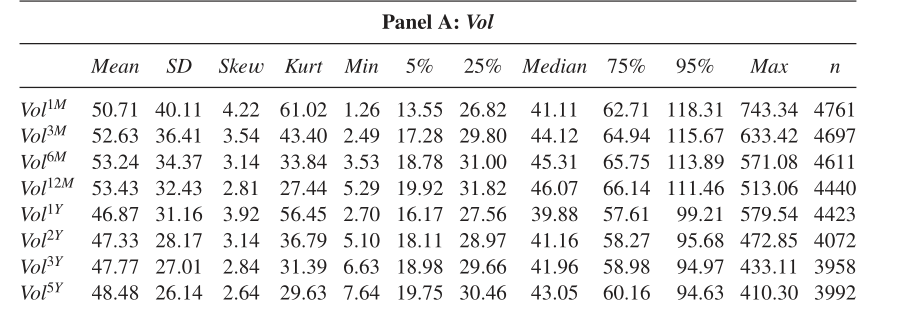

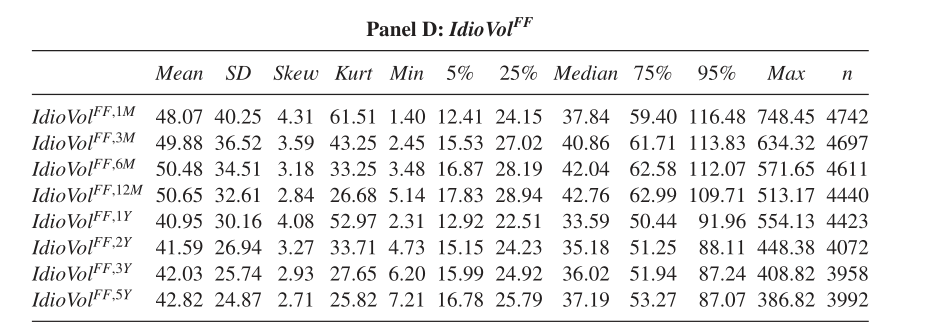

In [ ]:
#tb15_2、tb15_3相关系数
def cross_corr(x,b,kind):

    x_name=x.name
    y=b.loc[:,x_name]
    xy=pd.concat([x,y],join='inner',axis=1,sort=False)
    xy=xy.dropna()
    xy.columns=['x','y']
    return xy['x'].corr(xy['y'], method=kind)      
    
def get_tb15_2(data,name):   

    df_co=pd.DataFrame(index=name,columns=name)
    c=pd.DataFrame(index=data[0].columns,columns=['0'])
    
    for i in range(len(df_co)):
        for j in range(len(df_co)):
            a=data[i]
            b=data[j]
            if i<j:
                c.iloc[:,0]=a.apply(cross_corr,b=b,kind='spearman',axis=0)      
            elif i>j:
                c.iloc[:,0]=a.apply(cross_corr,b=b,kind='pearson',axis=0)  
            else:
                c.iloc[:,0]=np.nan
            df_co.iloc[i,j]=round(c.iloc[:,0].mean(),2)
    return df_co

tb15_2A=get_tb15_2(k[16:20]+k[36:40],namelist[16:20]+namelist[36:40])
tb15_2A.to_csv('tb15_2A.csv')
#tb15_2B=get_tb15_2(k[12:16]+k[32:36],namelist[16:20]+namelist[32:36])

tb15_3A=get_tb15_2(k[0:4]+k[20:24],namelist[0:4]+namelist[20:24])
tb15_3A.to_csv('tb15_3A.csv')
#tb15_3B=get_tb15_2(k[8:12]+k[28:32],namelist[8:12]+namelist[28:32])
#tb15_3C=get_tb15_2(k[4:8]+k[24:28],namelist[4:8]+namelist[24:28])

In [7]:
tb15_2A = pd.read_csv('tb15_2A.csv')
print(tb15_2A)

  Unnamed: 0  vol_1y  vol_2y  vol_3y  vol_5y  vol_12m  vol_1m  vol_3m  vol_6m
0     vol_1y     NaN    0.75    0.64    0.52     0.72    0.45    0.57    0.66
1     vol_2y    0.67     NaN    0.85    0.70     0.67    0.39    0.50    0.57
2     vol_3y    0.50    0.71     NaN    0.83     0.60    0.36    0.45    0.52
3     vol_5y    0.37    0.53    0.76     NaN     0.51    0.31    0.38    0.44
4    vol_12m    0.58    0.58    0.44    0.33      NaN    0.56    0.72    0.85
5     vol_1m    0.39    0.32    0.24    0.17     0.41     NaN    0.78    0.67
6     vol_3m    0.51    0.42    0.32    0.23     0.53    0.76     NaN    0.87
7     vol_6m    0.60    0.49    0.37    0.27     0.62    0.53    0.68     NaN


In [40]:
tb15_3A = pd.read_csv('tb15_3A.csv')
print(tb15_3A)

      Unnamed: 0  idio_capm_1y  idio_capm_2y  idio_capm_3y  idio_capm_5y  idio_capm_12m  idio_capm_1m  idio_capm_3m  idio_capm_6m
0   idio_capm_1y           NaN          0.75          0.63          0.51           0.73          0.42          0.56          0.66
1   idio_capm_2y          0.67           NaN          0.85          0.70           0.69          0.37          0.49          0.57
2   idio_capm_3y          0.49          0.71           NaN          0.83           0.62          0.34          0.44          0.52
3   idio_capm_5y          0.37          0.54          0.77           NaN           0.53          0.30          0.38          0.45
4  idio_capm_12m          0.58          0.59          0.46          0.35            NaN          0.52          0.69          0.84
5   idio_capm_1m          0.37          0.31          0.23          0.17           0.37           NaN          0.75          0.63
6   idio_capm_3m          0.50          0.41          0.32          0.23           0.49   

In [ ]:
#tb15_4相关系数
def get_tb15_4(k,namelist,kind):
    # kind='spearman'
    df_co=pd.DataFrame(index=list(range(10)),columns=['Correlation Between','1m','3m','6m','12m','1y','2y','3y','5y'])
    c=pd.DataFrame(index=k[0].columns,columns=['0'])  
    w=0
    for u in range(0,int(len(k)/8-1)):
        dt1=k[20+4*u:20+4*(u+1)]+k[4*u:4*(u+1)]
        name1=namelist[4*u][:-3]
        for v in range(u+1,int(len(k)/8)):
            dt2=k[20+4*v:20+4*(v+1)]+k[4*v:4*(v+1)]
            name2=namelist[4*v][:-3]
            
            df_co.iloc[w,0]=name1+' and ' +name2
            for i in range(len(dt1)):
                a=dt1[i]
                b=dt2[i]
                c.iloc[:,0]=a.apply(cross_corr,b=b,kind=kind,axis=0)
                df_co.iloc[w,i+1]=round(c.iloc[:,0].mean(),4)
            w=w+1   
    return df_co
        
tb15_4A=get_tb15_4(k,namelist,'spearman')
tb15_4A.to_csv('tb15_4A.csv')
#tb15_4B=get_tb15_4(k,namelist,'pearson')   

In [41]:
tb15_4A = pd.read_csv('tb15_4A.csv')
print(tb15_4A.iloc[:,1:])

      Correlation Between      1m      3m      6m     12m      1y      2y      3y      5y
0  idio_capm and idio_ffc  0.9833  0.9486  0.9748  0.9807  0.8679  0.9341  0.9480  0.9564
1   idio_capm and idio_ff  0.9850  0.9614  0.9792  0.9835  0.9014  0.9451  0.9553  0.9611
2     idio_capm and volss  0.8775  0.8326  0.8630  0.8737  0.7807  0.8263  0.8457  0.8682
3       idio_capm and vol  0.8761  0.8307  0.8613  0.8722  0.7822  0.8199  0.8392  0.8622
4    idio_ffc and idio_ff  0.9986  0.9862  0.9959  0.9977  0.9616  0.9884  0.9930  0.9954
5      idio_ffc and volss  0.8536  0.7828  0.8322  0.8474  0.6797  0.7696  0.7994  0.8296
6        idio_ffc and vol  0.8521  0.7808  0.8305  0.8458  0.6782  0.7627  0.7926  0.8233
7       idio_ff and volss  0.8552  0.7929  0.8362  0.8503  0.7047  0.7779  0.8052  0.8328
8         idio_ff and vol  0.8537  0.7912  0.8345  0.8487  0.7035  0.7705  0.7980  0.8262
9           volss and vol  0.9998  0.9935  0.9987  0.9995  0.9823  0.9936  0.9963  0.9978


In [ ]:
#tb15_5相关系数 
def Corr(data_list1, data_list2, kind,namelist0):
    result = []
    for df1 in data_list1:
        result_i = []
        for df2 in data_list2:
            temp = []
            for m in range(df1.shape[1]):
                if len(df1.iloc[:,m].dropna())>0 and len(df2.iloc[:,m].dropna())>0 :
                    temp.append(df1.iloc[:,m].corr(df2.iloc[:,m], method=kind))  # 每个截面上的相关系数
                else :
                    temp.append(np.nan)
            a=np.mean(pd.DataFrame(temp).dropna())
            result_i.append(a[0])
        result.append(result_i)
    
    result = pd.DataFrame(result)
    result.index=namelist0
    result.columns=['beta', 'size', 'bm','mom','rev']
    return result

tb15_5A=Corr(k[28:32]+k[8:12], [beta, size, bm,mom,rev], 'pearson',namelist[28:32]+namelist[8:12])
tb15_5A.to_csv('tb15_5A.csv')
#tb15_5B=Corr(k[28:32]+k[8:12], [beta, size, bm,mom,rev], 'spearman',namelist[28:32]+namelist[8:12])

In [8]:
tb15_5A = pd.read_csv('tb15_5A.csv')
print(tb15_5A)

    Unnamed: 0      beta      size        bm       mom       rev
0  idio_ff_12m  0.184619 -0.168482 -0.149696  0.268655  0.051305
1   idio_ff_1m  0.092116 -0.105308 -0.144463  0.291224  0.178028
2   idio_ff_3m  0.132631 -0.136063 -0.173876  0.347843  0.205603
3   idio_ff_6m  0.173026 -0.159862 -0.168687  0.370508  0.094995
4   idio_ff_1y  0.087815 -0.040199 -0.165296  0.348698  0.084244
5   idio_ff_2y  0.104644 -0.047352 -0.176007  0.165166  0.052363
6   idio_ff_3y  0.076441 -0.062988 -0.148261  0.102706  0.038139
7   idio_ff_5y  0.041109 -0.044272 -0.133157  0.058438  0.030992


In [ ]:
# 15.6 Persistence
def persis(data,t_list):
    result=pd.DataFrame(index=t_list,columns=['0'])
    for t in t_list:
        months=data.columns
        month=months[t:]
        data0=pd.DataFrame(index=month,columns=['0'])
        for i in range(data.shape[1]-t):
            data1 = data.iloc[:,[i,i+t]]
            data0.iloc[i,0] = data1.iloc[:,0].corr(data1.iloc[:,1])
        result.loc[t]=data0.iloc[:,0].mean()
    return result
        
tb15_6_1=persis(k[29],[1,3,6,12,24,36,48,60,120])        
tb15_6_2=persis(k[30],[3,6,12,24,36,48,60,120] )
tb15_6_3=persis(k[31],[6,12,24,36,48,60,120]) 
tb15_6_4=persis(k[28],[12,24,36,48,60,120]) 
tb15_6_5=persis(k[8],[24,36,48,60,120] )
tb15_6_6=persis(k[9],[36,48,60,120] )
tb15_6_7=persis(k[10],[48,60,120] )
tb15_6_8=persis(k[11],[60,120] )
tb15_6=pd.concat([tb15_6_1,tb15_6_2,tb15_6_3,tb15_6_4,tb15_6_5,tb15_6_6,tb15_6_7,tb15_6_8],join='outer',axis=1)
tb15_6.columns=[namelist[29],namelist[30],namelist[31],namelist[28],namelist[8],namelist[9],namelist[10],namelist[11]]
tb15_6.to_csv('tb15_6.csv')

In [10]:
tb15_6 = pd.read_csv('tb15_6.csv')
print(tb15_6)

   Unnamed: 0  idio_ff_1m  idio_ff_3m  idio_ff_6m  idio_ff_12m  idio_ff_1y  idio_ff_2y  idio_ff_3y  idio_ff_5y
0           1    0.381539         NaN         NaN          NaN         NaN         NaN         NaN         NaN
1           3    0.262280    0.446409         NaN          NaN         NaN         NaN         NaN         NaN
2           6    0.194430    0.318018    0.348310          NaN         NaN         NaN         NaN         NaN
3          12    0.140867    0.225708    0.236539     0.295882         NaN         NaN         NaN         NaN
4          24    0.103459    0.168431    0.171563     0.204552    0.101425         NaN         NaN         NaN
5          36    0.092080    0.147269    0.154905     0.180357    0.093482    0.139722         NaN         NaN
6          48    0.076622    0.129272    0.138125     0.161020    0.085715    0.132121    0.128112         NaN
7          60    0.076583    0.123925    0.133343     0.156484    0.082833    0.122227    0.109223    0.131778
8

In [29]:
# 15.7 Univariate Portfolio Analysis
def NWtest(a, lags=6):

    adj_a = pd.DataFrame(a)
    adj_a=adj_a.dropna()
    if len(adj_a)>0:
        adj_a=adj_a.astype(float)
        adj_a=np.array(adj_a)
        model = sm.OLS(adj_a, [1] * len(adj_a)).fit(cov_type='HAC', cov_kwds={'maxlags': lags})
        return float(model.tvalues), float(model.pvalues)
    else:
        return [np.nan]*2
    
def get_group(indicator,size,ret):

    months=ret.index
    dfew = pd.DataFrame(columns=list(range(10)),index=ret.index)
    dfvw = pd.DataFrame(columns=list(range(10)),index=ret.index)
    for m,month in enumerate(months):

        final=pd.concat([indicator.iloc[m,:],size.iloc[m,:],ret.iloc[m,:]],join='inner',axis=1)
        final.columns=['factor','size','ret']
        final=final.dropna()
        if len(final)<=10:
            continue
        else:
            final = final.sort_values(by='factor')
            final['VW'] = final.apply(lambda x: x['size'] * x['ret'], axis=1)
            
            k = []  
            for i in range(10):
                total = final.iloc[round(len(final) / 10 * i) :round(len(final) / 10 * (i + 1)), :]
                k.append(total)
        for j in range(10):
       #    j=0
           dfew.iloc[m,j]=k[j]['ret'].mean()
           dfvw.iloc[m,j]=k[j]['VW'].sum() / k[j]['size'].sum()
    dfew['10']=dfew[9]-dfew[0]
    dfvw['10']=dfvw[9]-dfvw[0]
    dfew=pd.DataFrame(dfew,dtype=np.float)
    dfvw=pd.DataFrame(dfvw,dtype=np.float)
    return  dfew,dfvw


def task(df,ff): 
    final=pd.DataFrame(index=list(range(2)),columns=['1','2','3','4','5','6','7','8','9','10','10-1','capm_a','ffc_a'])
    
    for i in range(df.shape[1]):
        #i=0
        vb=df.iloc[:,i]
        vb=vb.dropna()
        
        data=pd.concat([vb,ff], axis=1, join='inner')
        data.columns=['factor','mkt_rf','smb','hml','umd']
        
        #均值
        a=np.mean(data['factor'])
        final.iloc[0,i]=a
        if i >9:
            #t检验
            t=NWtest(data['factor'],0)[0]
        
            #α检验
            capm=smf.ols('factor~mkt_rf',data).fit(cov_type='HAC',cov_kwds={'maxlags':6})
            c_a=capm.params[0]
            c_t=capm.tvalues[0]  
            
            ffc=smf.ols('factor~mkt_rf+smb+hml+umd',data).fit(cov_type='HAC',cov_kwds={'maxlags':6})
            ffc_a=ffc.params[0]
            ffc_t=ffc.tvalues[0]  
            
            final.iloc[0,i]=str(round(a,2))
            final.iloc[1,i]='('+str(round(t,2))+')'
            final.iloc[0,i+1]=str(round(c_a,2))
            final.iloc[1,i+1]='('+str(round(c_t,2))+')'
            final.iloc[0,i+2]=str(round(ffc_a,2))
            final.iloc[1,i+2]='('+str(round(ffc_t,2))+')'
    return final



In [ ]:
idol_ff=k[29:32]+[k[28]]+k[8:12]
tb15_7A=pd.DataFrame(columns=['1','2','3','4','5','6','7','8','9','10','10-1','capm_a','ffc_a'])
tb15_7B=pd.DataFrame(columns=['1','2','3','4','5','6','7','8','9','10','10-1','capm_a','ffc_a'])
for x in idol_ff:
    dfew,dfvw=get_group(x.T,size.T,ret0.T)
    final1=task(dfvw,ff)
    final2=task(dfew,ff)
    tb15_7A=pd.concat([tb15_7A, final1], axis=0,join='inner',sort=False)
    tb15_7B=pd.concat([tb15_7B, final2], axis=0,join='inner',sort=False)

tb15_7A_index=[]  
for i in namelist[29:32]+[namelist[28]]+namelist[8:12]:
    tb15_7A_index.append(i)
    tb15_7A_index.append(np.nan)
tb15_7A.index=tb15_7A_index
tb15_7A.to_csv('tb15_7A.csv')
tb15_7B.index=tb15_7A_index
tb15_7B.to_csv('tb15_7B.csv')

In [11]:
tb15_7A = pd.read_csv('tb15_7A.csv')
tb15_7A=round(tb15_7A,2)
print(tb15_7A)

     Unnamed: 0     1     2     3     4     5     6     7     8     9    10     10-1   capm_a    ffc_a
0    idio_ff_1m  1.77  1.99  1.97  1.96  1.86  1.83  1.66  1.52  1.28  0.78    -0.99    -1.11    -1.06
1           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  (-3.47)  (-3.99)  (-4.54)
2    idio_ff_3m  1.59  1.96  1.92  1.89  1.79  1.75  1.74  1.51  1.39  1.06    -0.53    -0.68    -0.55
3           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  (-1.59)  (-2.45)  (-2.49)
4    idio_ff_6m  1.55  1.93  1.86  1.75  1.80  1.83  1.57  1.68  1.48  1.20    -0.35    -0.49    -0.39
5           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  (-1.03)  (-1.83)  (-1.73)
6   idio_ff_12m  1.62  1.73  1.83  1.80  1.72  1.82  1.68  1.72  1.53  1.06    -0.56    -0.72    -0.56
7           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  (-1.65)  (-2.72)  (-2.83)
8    idio_ff_1y  1.88  1.84  1.68  1.74  1.76  1.75  1.60  1.65  1.55  1.

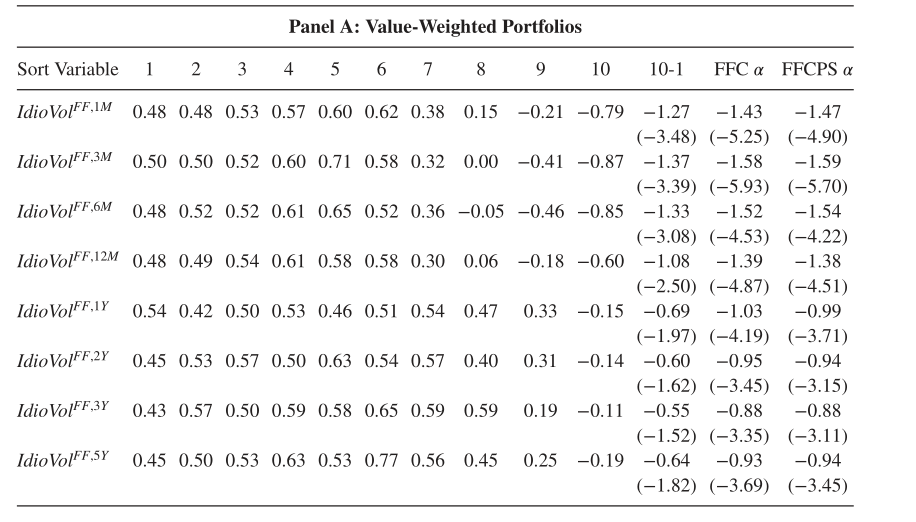

In [12]:
tb15_7B = pd.read_csv('tb15_7B.csv')
tb15_7B=round(tb15_7B,2)
print(tb15_7B)

     Unnamed: 0     1     2     3     4     5     6     7     8     9    10     10-1   capm_a    ffc_a
0    idio_ff_1m  1.86  2.09  2.05  2.05  1.96  1.92  1.77  1.62  1.38  0.86    -0.99    -1.11    -1.06
1           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  (-3.51)  (-4.04)  (-4.58)
2    idio_ff_3m  1.66  2.05  2.00  1.98  1.88  1.85  1.85  1.61  1.49  1.18    -0.48    -0.63     -0.5
3           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  (-1.45)  (-2.32)  (-2.31)
4    idio_ff_6m  1.61  2.01  1.94  1.84  1.89  1.91  1.66  1.79  1.60  1.33    -0.28    -0.41    -0.31
5           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  (-0.82)  (-1.57)  (-1.43)
6   idio_ff_12m  1.68  1.81  1.91  1.88  1.81  1.91  1.78  1.83  1.65  1.16    -0.52    -0.67    -0.51
7           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  (-1.56)  (-2.59)  (-2.63)
8    idio_ff_1y  1.96  1.92  1.76  1.82  1.86  1.85  1.69  1.74  1.66  1.

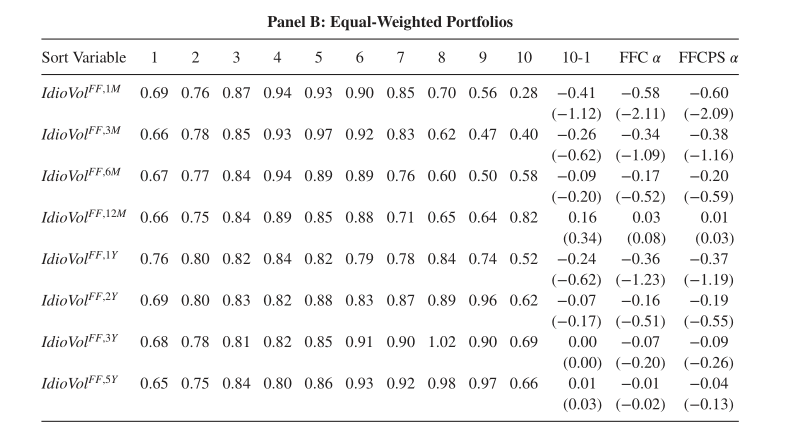

In [ ]:
# 15.9 
def PortChar(X, data_list):
    result = []
    for df in data_list:
        result_i = []
        for i in range(len(X.columns)):
            temp = pd.concat([X.iloc[:,i], df.iloc[:,i]], axis=1, keys=['a', 'b'])
            temp = temp[temp['a'].notna()]  # 只保留X为非na的情况
            if len(temp)>0:
                group = pd.qcut(temp['a'], 10, labels=False)
                result_i.append(temp['b'].groupby(group).mean().tolist())
        result.append(pd.DataFrame(result_i).mean().tolist())
    
    return pd.DataFrame(result)
tb15_9=PortChar(k[29], [k[29],beta, MktCap, bm,mom, rev])
tb15_9.columns=['1','2','3','4','5','6','7','8','9','10']
tb15_9.index=['idol_ff_1m','beta', 'mktcap', 'bm','mom', 'rev']
tb15_9.to_csv('tb15_9.csv')

In [45]:
tb15_9 = pd.read_csv('tb15_9.csv')
tb15_9=round(tb15_9,2)
print(tb15_9)

   Unnamed: 0         1        2        3        4        5        6        7        8        9       10
0  idol_ff_1m      2.63     3.53     4.12     4.66     5.20     5.77     6.44     7.27     8.45    11.45
1        beta      1.00     1.07     1.08     1.08     1.09     1.09     1.10     1.10     1.11     1.12
2      mktcap  13163.54  8110.09  7350.55  6938.34  6611.73  6381.26  6230.05  5766.44  5310.60  4739.58
3          bm      1.18     1.04     0.96     0.91     0.87     0.85     0.81     0.78     0.77     0.73
4         mom      2.14     6.65    11.05    15.25    18.60    22.96    27.57    33.34    38.46    52.79
5         rev     -2.29    -1.91    -1.37    -0.70     0.05     0.87     1.69     3.14     5.01    10.67


In [ ]:
# 15.10-13 Bivariate Portfolio Analysis
def get_indep_group(X1,X2,weight,ret,ff,u=5,v=5):
    months=ret.index 
    datacolumn = []
    for a in range(u):
        for b in range(v):
            datacolumn.append(str(a + 1) + 'X' + str(b + 1))   #生成25组的列名
    dfew = pd.DataFrame(columns=datacolumn,index=ret.index)
    dfvw = pd.DataFrame(columns=datacolumn, index=ret.index)
    for m in range(len(months)):
        final=pd.concat([X1.iloc[m,:],X2.iloc[m,:],weight.iloc[m,:],ret.iloc[m,:]],join='inner',axis=1)
        final.columns=['X1','X2','size','ret']
        final=final.dropna()
        if len(final)<u*v:
            continue
        else:
            final['VW'] = final.apply(lambda x: x['size'] * x['ret'], axis=1)
            final['分组1']=np.nan
            final['分组2']=np.nan
            
            final = final.sort_values(by='X1')
            for i in range(u):
                final.iloc[round(len(final) / u * i) :round(len(final) / u * (i + 1)), 5]=i+1
         
            final = final.sort_values(by='X2')
            for j in range(v):
                final.iloc[round(len(final) / v * j) :round(len(final) / v * (j + 1)), 6]=j+1     

            for i in range(u):
                for j in range(v):

                    total=final[(final['分组1']==i+1)&(final['分组2']==j+1)]
                    dfew.iloc[m,v*i+j]=total['ret'].mean()
                    dfvw.iloc[m,v*i+j]=total['VW'].sum() / total['size'].sum()

    dfew=pd.DataFrame(dfew,dtype=np.float)
    dfvw=pd.DataFrame(dfvw,dtype=np.float)   
    return dfew,dfvw

def get_dep_group(X1,X2,weight,ret,ff,u=5,v=5):

    months=ret.index 
    datacolumn = []
    for a in range(u):
        for b in range(v):
            datacolumn.append(str(a + 1) + 'X' + str(b + 1))   #生成25组的列名
    dfew = pd.DataFrame(columns=datacolumn,index=ret.index)
    dfvw = pd.DataFrame(columns=datacolumn, index=ret.index)
    for m in range(len(months)):
  
        final=pd.concat([X1.iloc[m,:],X2.iloc[m,:],weight.iloc[m,:],ret.iloc[m,:]],join='inner',axis=1)
        final.columns=['X1','X2','size','ret']
        final=final.dropna()
        if len(final)<u*v:
            continue
        else:
            final['VW'] = final.apply(lambda x: x['size'] * x['ret'], axis=1)
            final = final.sort_values(by='X1')
                        
            h = []
            for i in range(u):
                total = final.iloc[round(len(final) / u * i) :round(len(final) / u * (i + 1)), :]
                total = total.sort_values(by='X2')
                for j in range(v):                   
                    total2 =total.iloc[round(len(total) / v * j) :round(len(total) / v * (j + 1)), :]
                    h.append(total2)
                
        for w in range(len(h)):
            dfew.iloc[m,w]=h[w]['ret'].mean()
            dfvw.iloc[m,w]=h[w]['VW'].sum() / h[w]['size'].sum()
    dfew=pd.DataFrame(dfew,dtype=np.float)
    dfvw=pd.DataFrame(dfvw,dtype=np.float)   
    return dfew,dfvw           

def task2(dfew,ff)  :  
    resultew = pd.DataFrame(columns=['control','value','control 1','control 2','control 3','control 4','control 5','control ave'],index=list(range(6)))

    for i in range(5):
        # i=0
        xyew=pd.DataFrame(dfew.iloc[:,i*5-1]-dfew.iloc[:,i*5])
        xyew=xyew.dropna()
        resultew.iloc[0,i+2]=round(xyew[0].mean(),2)
        resultew.iloc[1,i+2]='('+str(round(NWtest(xyew[0],0)[0],2))+')'       

        data=pd.concat([xyew,ff], axis=1, join='inner')
        data.columns=['factor','mkt_rf','smb','hml','umd']

        #α检验
        capm=smf.ols('factor~mkt_rf',data).fit(cov_type='HAC',cov_kwds={'maxlags':6})
        resultew.iloc[2,i+2]=round(capm.params[0],2)
        resultew.iloc[3,i+2]='('+str(round(capm.tvalues[0],2))+')'    
        
        ffc=smf.ols('factor~mkt_rf+smb+hml+umd',data).fit(cov_type='HAC',cov_kwds={'maxlags':6})
        resultew.iloc[4,i+2]=round(ffc.params[0],2)
        resultew.iloc[5,i+2]='('+str(round(ffc.tvalues[0],2))+')'     

    xyew=0.2*pd.DataFrame(dfew.iloc[:,4]+dfew.iloc[:,9]+dfew.iloc[:,14]+dfew.iloc[:,19]+dfew.iloc[:,24]
                      -dfew.iloc[:,0]-dfew.iloc[:,5]-dfew.iloc[:,10]-dfew.iloc[:,15]-dfew.iloc[:,0])
    xyew=xyew.dropna()
    resultew.iloc[0,-1]=round(xyew[0].mean(),2)
    resultew.iloc[1,-1]='('+str(round(NWtest(xyew[0],0)[0],2))+')'        

    data=pd.concat([xyew,ff], axis=1, join='inner')
    data.columns=['factor','mkt_rf','smb','hml','umd']

    capm=smf.ols('factor~mkt_rf',data).fit(cov_type='HAC',cov_kwds={'maxlags':6})
    resultew.iloc[2,-1]=round(capm.params[0],2)
    resultew.iloc[3,-1]='('+str(round(capm.tvalues[0],2))+')'    
    
    ffc=smf.ols('factor~mkt_rf+smb+hml+umd',data).fit(cov_type='HAC',cov_kwds={'maxlags':6})
    resultew.iloc[4,-1]=round(ffc.params[0],2)
    resultew.iloc[5,-1]='('+str(round(ffc.tvalues[0],2))+')'

    resultew.iloc[:,1]=['return',np.nan,'capm a',np.nan,'ffc a',np.nan]

    return resultew

In [ ]:
# Bivariate Dependent-Sort Portfolio Analysis
vol_ff_1m=k[29]
tb15_10=pd.DataFrame(columns=['control','value','control 1','control 2','control 3','control 4','control 5','control ave'])
tb15_11=pd.DataFrame(columns=['control','value','control 1','control 2','control 3','control 4','control 5','control ave'])
for x in [beta, MktCap, bm,mom, rev]:
    dfew,dfvw=get_dep_group(x.T,vol_ff_1m.T,size.T,ret0.T,ff)
    final1=task2(dfvw,ff)
    final2=task2(dfew,ff)
    tb15_10=pd.concat([tb15_10, final1], axis=0,join='inner',sort=False)
    tb15_11=pd.concat([tb15_11, final2], axis=0,join='inner',sort=False)
control_index=['beta',np.nan, np.nan,np.nan,np.nan,np.nan,
            'mktcap',np.nan, np.nan,np.nan,np.nan,np.nan,
            'bm',np.nan, np.nan,np.nan,np.nan,np.nan,
            'mom', np.nan, np.nan,np.nan,np.nan,np.nan,
            'rev',np.nan, np.nan,np.nan,np.nan,np.nan]    
tb15_10.iloc[:,0]=control_index
tb15_10.to_csv('tb15_10.csv')
tb15_11.iloc[:,0]=control_index
tb15_11.to_csv('tb15_11.csv')

In [37]:
tb15_10 = pd.read_csv('tb15_10.csv')
tb15_10=round(tb15_10.iloc[:,1:],2)
print(tb15_10)

   control   value control 1 control 2 control 3 control 4 control 5 control ave
0     beta  return     -0.63     -1.22     -0.65     -0.91      -0.9       -0.73
1      NaN     NaN   (-1.52)   (-4.67)   (-2.56)   (-3.99)   (-3.15)     (-3.22)
2      NaN  capm a     -0.92     -1.19     -0.67     -0.94     -0.89       -0.85
3      NaN     NaN   (-2.46)   (-3.86)   (-2.71)   (-4.36)    (-2.7)     (-3.77)
4      NaN   ffc a     -0.99     -1.04     -0.48      -0.9     -0.79       -0.81
5      NaN     NaN    (-2.8)   (-3.99)   (-2.14)   (-4.59)   (-2.72)      (-4.2)
6   mktcap  return     -3.49      0.44     -0.26     -1.26      -0.8       -1.64
7      NaN     NaN   (-8.54)    (1.37)    (-1.1)   (-4.74)    (-2.6)     (-7.37)
8      NaN  capm a     -3.47      0.34     -0.34     -1.34     -0.96       -1.69
9      NaN     NaN   (-6.48)    (1.34)   (-1.49)   (-4.56)   (-2.84)     (-6.62)
10     NaN   ffc a     -2.86      0.38     -0.37     -1.36     -1.09       -1.49
11     NaN     NaN   (-7.81)

In [46]:
tb15_11 = pd.read_csv('tb15_11.csv')
tb15_11=round(tb15_11.iloc[:,1:],2)
print(tb15_11)

   control   value control 1 control 2 control 3 control 4 control 5 control ave
0     beta  return     -0.59     -1.23     -0.66     -0.92     -0.91       -0.72
1      NaN     NaN   (-1.46)   (-4.78)   (-2.61)   (-4.06)   (-3.21)     (-3.22)
2      NaN  capm a     -0.88      -1.2     -0.69     -0.96      -0.9       -0.84
3      NaN     NaN   (-2.37)   (-3.93)   (-2.73)    (-4.5)    (-2.8)     (-3.76)
4      NaN   ffc a     -0.94     -1.07     -0.51     -0.91      -0.8        -0.8
5      NaN     NaN   (-2.69)   (-4.12)   (-2.23)   (-4.68)   (-2.81)     (-4.19)
6   mktcap  return     -3.51      0.46     -0.26     -1.27     -0.82       -1.64
7      NaN     NaN   (-8.61)    (1.42)   (-1.07)   (-4.76)   (-2.68)      (-7.4)
8      NaN  capm a     -3.49      0.36     -0.34     -1.35     -0.97       -1.69
9      NaN     NaN   (-6.51)    (1.42)   (-1.46)   (-4.56)   (-2.89)     (-6.63)
10     NaN   ffc a     -2.89       0.4     -0.36     -1.36      -1.1        -1.5
11     NaN     NaN   (-7.83)

In [ ]:
# Bivariate Independent-Sort Portfolio Analysis
tb15_12=pd.DataFrame(columns=['control','value','control 1','control 2','control 3','control 4','control 5','control ave'])
tb15_13=pd.DataFrame(columns=['control','value','control 1','control 2','control 3','control 4','control 5','control ave'])
for x in [beta, MktCap, bm,mom, rev]:
    dfew,dfvw=get_indep_group(x.T,vol_ff_1m.T,size.T,ret0.T,ff)
    final1=task2(dfvw,ff)
    final2=task2(dfew,ff)
    tb15_12=pd.concat([tb15_12, final1], axis=0,join='inner',sort=False)
    tb15_13=pd.concat([tb15_13, final2], axis=0,join='inner',sort=False)
tb15_12.iloc[:,0]=control_index
tb15_12.to_csv('tb15_12.csv')
tb15_13.iloc[:,0]=control_index
tb15_13.to_csv('tb15_13.csv')

In [47]:
tb15_12 = pd.read_csv('tb15_12.csv')
tb15_12=round(tb15_12.iloc[:,1:],2)
print(tb15_12)

   control   value control 1 control 2 control 3 control 4 control 5 control ave
0     beta  return     -0.59     -1.29     -0.79     -0.96     -0.88       -0.78
1      NaN     NaN   (-1.48)   (-4.92)   (-3.12)   (-4.22)   (-2.88)     (-3.47)
2      NaN  capm a      -0.9     -1.27      -0.8      -1.0     -0.86        -0.9
3      NaN     NaN   (-2.56)   (-4.23)   (-3.25)    (-4.5)   (-2.41)     (-4.01)
4      NaN   ffc a     -0.93     -1.15     -0.64     -0.99     -0.75       -0.87
5      NaN     NaN   (-2.81)   (-4.47)   (-2.77)   (-4.85)   (-2.43)     (-4.43)
6   mktcap  return      -3.4      0.49     -0.22     -1.23     -0.93        -1.6
7      NaN     NaN    (-7.8)    (1.63)   (-0.88)    (-4.7)   (-3.07)      (-7.0)
8      NaN  capm a      -3.4      0.41      -0.3      -1.3     -1.09       -1.66
9      NaN     NaN   (-6.15)    (1.64)    (-1.3)   (-4.57)   (-3.21)     (-6.37)
10     NaN   ffc a     -2.79      0.43     -0.31     -1.33     -1.22       -1.46
11     NaN     NaN   (-7.05)

In [48]:
tb15_13 = pd.read_csv('tb15_13.csv')
tb15_13=round(tb15_13.iloc[:,1:],2)
print(tb15_13)

   control   value control 1 control 2 control 3 control 4 control 5 control ave
0     beta  return     -0.56     -1.32     -0.79     -0.98     -0.88       -0.77
1      NaN     NaN    (-1.4)   (-5.08)   (-3.16)   (-4.31)    (-2.9)     (-3.46)
2      NaN  capm a     -0.86      -1.3     -0.81     -1.01     -0.86       -0.89
3      NaN     NaN   (-2.47)   (-4.35)   (-3.25)   (-4.64)   (-2.47)     (-4.01)
4      NaN   ffc a     -0.88     -1.18     -0.66      -1.0     -0.76       -0.86
5      NaN     NaN    (-2.7)   (-4.67)   (-2.84)   (-4.93)   (-2.49)     (-4.43)
6   mktcap  return     -3.42      0.51     -0.21     -1.23     -0.95       -1.61
7      NaN     NaN   (-7.87)    (1.68)   (-0.84)   (-4.71)   (-3.16)     (-7.03)
8      NaN  capm a     -3.42      0.43     -0.29      -1.3      -1.1       -1.67
9      NaN     NaN   (-6.17)    (1.72)   (-1.27)   (-4.57)   (-3.27)     (-6.36)
10     NaN   ffc a     -2.82      0.45      -0.3     -1.34     -1.23       -1.47
11     NaN     NaN   (-7.08)

In [ ]:
# Fama–MacBeth Regression Analysis
def get_tb15_14(X1,X_list,ret,blank1,blank2):

    months=ret.index
    fm_result=pd.DataFrame(index=months,columns=list(range(2+len(X_list)+2)))
   
    for m in range(len(months)):

        final=pd.concat([ret.iloc[m,:],X1.iloc[m,:]],join='inner',axis=1)
        if len(X_list)>0:
            for X0 in X_list:
                # X0=X_list[0]
                final=pd.concat([final,X0.iloc[m,:]],join='inner',axis=1)
        final = final.dropna()
        if len(final)>0:
            final.iloc[:, 1:] =stats.mstats.winsorize(final.iloc[:, 1:] ,(0.01,0.01))
            model = sm.OLS(final.iloc[:, 0],sm.add_constant(final.iloc[:, 1:])).fit()  # 回归
            fm_result.iloc[m,0:-2]=model.params.values
            fm_result.iloc[m,-2]=model.rsquared_adj
            fm_result.iloc[m,-1]=len(final)
        else: 
            fm_result.iloc[m,:]=np.nan

    fm_result2=pd.DataFrame(index=list(range(8*2)),columns=['0'])  
    for j in range(fm_result.shape[1]):
     
        if j <fm_result.shape[1]-2:
            fm_result2.iloc[2*j,0]=round(fm_result.iloc[:,j].mean(), 4)
            fm_result2.iloc[2*j+1,0]='('+str(round(NWtest(fm_result.iloc[:,j],0)[0],2))+')'
        else:
            fm_result2.iloc[-2,0]=round(fm_result.iloc[:,-2].mean(), 4)
            fm_result2.iloc[-1,0]=round(fm_result.iloc[:,-1].mean(), 0)
        
    fm=pd.DataFrame(index=list(range(8*2)),columns=['0'])  
    fm.iloc[0:2,0]=fm_result2.iloc[2:4,0].values
    fm.iloc[2:2+blank1,0]=np.nan*blank1
    fm.iloc[2+blank1:len(fm_result2)-4-blank2,0]=fm_result2.iloc[4:len(fm_result2)-blank1-blank2-2,0].values
    fm.iloc[len(fm_result2)-4-blank2:-4,0]=np.nan*blank2
    fm.iloc[-4:-2,0]=fm_result2.iloc[0:2,0].values
    fm.iloc[-2:,0]=fm_result2.iloc[-2:,0]

    return fm

In [ ]:
# 15.14
ret1=ret0/100
rev1=rev/100
mom1=mom/100
tb15_14_1=get_tb15_14(vol_ff_1m.T,[],ret1.T,0,10)
tb15_14_2=get_tb15_14(vol_ff_1m.T,[beta.T],ret1.T,0,8)
tb15_14_3=get_tb15_14(vol_ff_1m.T,[size.T],ret1.T,2,6)
tb15_14_4=get_tb15_14(vol_ff_1m.T,[bm.T],ret1.T,4,4)
tb15_14_5=get_tb15_14(vol_ff_1m.T,[mom1.T],ret1.T,6,2)
tb15_14_6=get_tb15_14(vol_ff_1m.T,[rev.T],ret1.T,8,0)
tb15_14_7=get_tb15_14(vol_ff_1m.T,[beta.T,size.T,bm.T,mom1.T,rev1.T],ret1.T,0,0)              
tb15_14=pd.concat([tb15_14_1,tb15_14_2,tb15_14_3,tb15_14_4,tb15_14_5,tb15_14_6,tb15_14_7],join='inner',axis=1)
tb15_14.columns=['(1)','(2)','(3)','(4)','(5)','(6)','(7)']
index2=['idol_ff_1m',np.nan, 'beta',np.nan,'size',np.nan,'bm',np.nan, 
            'mom', np.nan,'rev',np.nan,'intercept',np.nan,'adj_R2','n']      
tb15_14.index=index2
tb15_14.to_csv('tb15_14.csv')

In [26]:
tb15_14 = pd.read_csv('tb15_14.csv')
#tb15_14=round(tb15_14,2)
print(tb15_14)

    Unnamed: 0      (1)      (2)      (3)      (4)      (5)      (6)      (7)
0   idol_ff_1m  -0.0014  -0.0015  -0.0018  -0.0014  -0.0015  -0.0015  -0.0023
1          NaN  (-4.27)  (-4.83)  (-5.67)   (-4.6)  (-4.99)  (-4.59)  (-8.42)
2         beta      NaN   0.0035      NaN      NaN      NaN      NaN  -0.0038
3          NaN      NaN   (0.66)      NaN      NaN      NaN      NaN  (-0.84)
4         size      NaN      NaN  -0.0106      NaN      NaN      NaN   -0.011
5          NaN      NaN      NaN  (-7.16)      NaN      NaN      NaN  (-7.92)
6           bm      NaN      NaN      NaN  -0.0004      NaN      NaN  -0.0025
7          NaN      NaN      NaN      NaN  (-0.32)      NaN      NaN  (-2.09)
8          mom      NaN      NaN      NaN      NaN   -0.001      NaN   0.0033
9          NaN      NaN      NaN      NaN      NaN  (-0.26)      NaN   (1.16)
10         rev      NaN      NaN      NaN      NaN      NaN  -0.0001  -0.0112
11         NaN      NaN      NaN      NaN      NaN      NaN  (-1

In [ ]:
# 15.15
tb15_15_1=get_tb15_14(k[29].T,[beta.T,size.T,bm.T,mom1.T,rev1.T],ret1.T,0,0)    
tb15_15_2=get_tb15_14(k[30].T,[beta.T,size.T,bm.T,mom1.T,rev1.T],ret1.T,0,0)  
tb15_15_3=get_tb15_14(k[31].T,[beta.T,size.T,bm.T,mom1.T,rev1.T],ret1.T,0,0)  
tb15_15_4=get_tb15_14(k[28].T,[beta.T,size.T,bm.T,mom1.T,rev1.T],ret1.T,0,0)  
tb15_15_5=get_tb15_14(k[8].T,[beta.T,size.T,bm.T,mom1.T,rev1.T],ret1.T,0,0)  
tb15_15_6=get_tb15_14(k[9].T,[beta.T,size.T,bm.T,mom1.T,rev1.T],ret1.T,0,0)  
tb15_15_7=get_tb15_14(k[10].T,[beta.T,size.T,bm.T,mom1.T,rev1.T],ret1.T,0,0)  
tb15_15_8=get_tb15_14(k[11].T,[beta.T,size.T,bm.T,mom1.T,rev1.T],ret1.T,0,0)           
tb15_15=pd.concat([tb15_15_1,tb15_15_2,tb15_15_3,tb15_15_4,tb15_15_5,tb15_15_6,tb15_15_7,tb15_15_8],join='inner',axis=1)
tb15_15.columns=['1m','3m','6m','12m','1y','2y','3y','5y']
index3=['idol_ff',np.nan, 'beta',np.nan,'size',np.nan,'bm',np.nan, 
            'mom', np.nan,'rev',np.nan,'intercept',np.nan,'adj_R2','n']  
tb15_15.index=index3
tb15_15.to_csv('tb15_15.csv')

In [62]:
tb15_15 = pd.read_csv('tb15_15.csv')
print(tb15_15)

   Unnamed: 0       1m       3m       6m      12m       1y       2y       3y       5y
0     idol_ff  -0.0023  -0.0033  -0.0048  -0.0066  -0.0007  -0.0012  -0.0015  -0.0017
1         NaN  (-8.42)  (-5.88)  (-5.14)  (-5.53)  (-3.38)  (-4.18)  (-4.22)  (-4.12)
2        beta  -0.0038  -0.0033  -0.0023  -0.0015  -0.0039  -0.0039  -0.0038  -0.0041
3         NaN  (-0.84)  (-0.74)  (-0.53)  (-0.35)  (-0.89)  (-0.88)  (-0.87)   (-0.9)
4        size   -0.011   -0.013  -0.0131  -0.0134  -0.0106  -0.0112   -0.012  -0.0125
5         NaN  (-7.92)  (-8.48)  (-8.62)  (-8.75)  (-7.65)  (-7.76)  (-7.98)  (-8.02)
6          bm  -0.0025  -0.0029   -0.003  -0.0031  -0.0019  -0.0024  -0.0029   -0.003
7         NaN  (-2.09)  (-2.59)   (-2.6)  (-2.76)  (-1.65)  (-1.74)  (-2.04)  (-2.08)
8         mom   0.0033    0.005   0.0053   0.0045   0.0026   0.0034    0.003   0.0025
9         NaN   (1.16)    (1.7)   (1.77)    (1.5)   (0.86)   (1.15)   (1.01)   (0.86)
10        rev  -0.0112  -0.0271  -0.0316   -0.032  -0.

In [ ]:
# 15.16
tb15_16_1=get_tb15_14(k[37].T,[beta.T,size.T,bm.T,mom1.T,rev1.T],ret1.T,0,0)    
tb15_16_2=get_tb15_14(k[38].T,[beta.T,size.T,bm.T,mom1.T,rev1.T],ret1.T,0,0)  
tb15_16_3=get_tb15_14(k[39].T,[beta.T,size.T,bm.T,mom1.T,rev1.T],ret1.T,0,0)  
tb15_16_4=get_tb15_14(k[36].T,[beta.T,size.T,bm.T,mom1.T,rev1.T],ret1.T,0,0)  
tb15_16_5=get_tb15_14(k[16].T,[beta.T,size.T,bm.T,mom1.T,rev1.T],ret1.T,0,0)  
tb15_16_6=get_tb15_14(k[17].T,[beta.T,size.T,bm.T,mom1.T,rev1.T],ret1.T,0,0)  
tb15_16_7=get_tb15_14(k[18].T,[beta.T,size.T,bm.T,mom1.T,rev1.T],ret1.T,0,0)  
tb15_16_8=get_tb15_14(k[19].T,[beta.T,size.T,bm.T,mom1.T,rev1.T],ret1.T,0,0)           
tb15_16=pd.concat([tb15_16_1,tb15_16_2,tb15_16_3,tb15_16_4,tb15_16_5,tb15_16_6,tb15_16_7,tb15_16_8],join='inner',axis=1)
tb15_16.columns=['1m','3m','6m','12m','1y','2y','3y','5y']
tb15_16.index=['vol',np.nan, 'beta',np.nan,'size',np.nan,'bm',np.nan, 
            'mom', np.nan,'rev',np.nan,'intercept',np.nan,'adj_R2','n']  
tb15_16.to_csv('tb15_16.csv')

In [64]:
tb15_16 = pd.read_csv('tb15_16.csv')
print(tb15_16)

   Unnamed: 0       1m       3m       6m      12m       1y       2y       3y       5y
0         vol   -0.001  -0.0021  -0.0039  -0.0066  -0.0001  -0.0005  -0.0008  -0.0011
1         NaN  (-3.16)  (-3.12)   (-3.4)  (-4.38)  (-0.37)  (-1.81)  (-2.19)  (-2.47)
2        beta  -0.0034  -0.0014   0.0012   0.0045   -0.005  -0.0041  -0.0038  -0.0034
3         NaN  (-0.84)  (-0.37)   (0.31)   (1.07)  (-1.24)  (-1.02)  (-0.93)  (-0.82)
4        size  -0.0101  -0.0121  -0.0128  -0.0132  -0.0103  -0.0106  -0.0111  -0.0119
5         NaN  (-7.51)  (-8.32)  (-8.51)  (-8.73)  (-7.55)  (-7.64)  (-7.77)  (-7.92)
6          bm  -0.0015  -0.0023  -0.0026  -0.0029  -0.0013  -0.0016  -0.0021  -0.0026
7         NaN  (-1.31)  (-2.12)  (-2.29)  (-2.61)  (-1.19)  (-1.18)  (-1.51)  (-1.79)
8         mom   0.0017   0.0038   0.0043    0.004    0.001   0.0025   0.0025   0.0024
9         NaN    (0.6)   (1.32)   (1.48)   (1.34)   (0.34)   (0.83)   (0.86)   (0.82)
10        rev  -0.0227  -0.0274  -0.0306  -0.0318  -0.

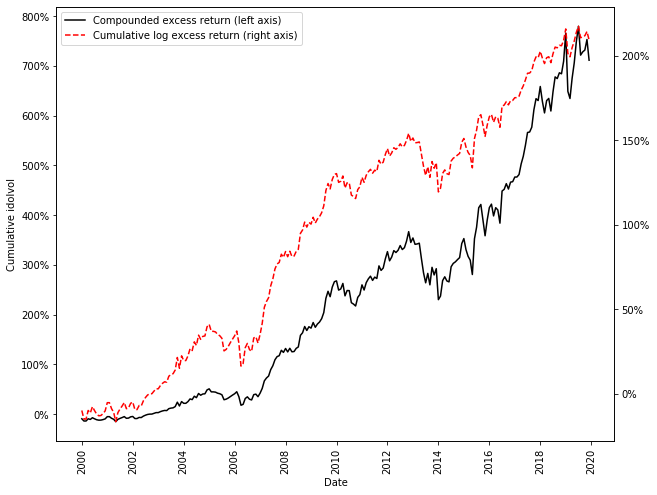

In [30]:
# 累计收益图
def plot_Cum_Ret(factor_ret, y, size=(10, 8)):
    # factor_ret=idolvol_factor
    # y='Cumulative idolvol'

    comp = (factor_ret + 1).cumprod() - 1
    cumlog = np.log((factor_ret + 1).tolist()).cumsum()

    fig = plt.figure(figsize=size)
    ax1 = fig.add_subplot(111)
    lns1=ax1.plot(comp*100, '-k', label = 'Compounded excess return (left axis)')
    plt.xticks(rotation=90)
    ax2 = ax1.twinx()
    lns2= ax2.plot(cumlog*100, '--r', label = 'Cumulative log excess return (right axis)')
    lns = lns1+lns2
    plt.xticks(range(0,241,24),range(2000,2021,2))
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0)
    fmt='%.0f%%'
    yticks = mtick.FormatStrFormatter(fmt)
    ax1.yaxis.set_major_formatter(yticks)
    ax2.yaxis.set_major_formatter(yticks)
    ax1.set_xlabel('Date')
    ax1.set_ylabel(y)

idolvol_factor_ew=get_group(k[29].T,size.T,ret0.T)[1]
idolvol_factor_ew=idolvol_factor_ew.fillna(0)
idolvol_factor=-idolvol_factor_ew.iloc[:,-1]/ 100

plot_Cum_Ret(idolvol_factor, 'Cumulative idolvol')